# Ocular Diseases Classification using Deep Learning Techniques
## Project Overview
This project aims to develop a deep learning model for the classification of retinal images to identify various eye diseases. The focus is on four specific conditions: **Normal, Diabetic Retinopathy, Cataract, and Glaucoma**. 

By analyzing these images, we can assist in early diagnosis and treatment, ultimately improving patient outcomes.

## Dataset Description
The dataset used for this project comprises retinal images categorized into four classes:
* Normal: Healthy retinal images with no abnormalities
* Diabetic Retinopathy: Images showing signs of diabetic eye disease.
* Cataract: Images indicating the presence of cataracts in the lens of the eye.
* Glaucoma: Images that reveal signs of glaucoma, which affects the optic nerve.

Each class contains approximately 1,000 images, providing a balanced dataset for training and evaluation. The images have been sourced from various reputable databases, including:

* IDRiD: Indian Diabetic Retinopathy Image Dataset
* Ocular Recognition: A database focused on ocular disease recognition
* HRF: High-Resolution Fundus dataset

Source of Dataset:
*https://www.kaggle.com/datasets/gunavenkatdoddi/eye-diseases-classification/data*

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import seaborn as sns
sns.set_style("darkgrid")
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from keras_tqdm import TQDMNotebookCallback

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from powermanagement import long_running 

%autosave 30

Autosaving every 30 seconds


In [2]:
telltimefnx = lambda :print(f"Time Now: {pd.Timestamp.now().strftime('%Y.%m.%d %I:%M %p')}")
telltimefnx()

Time Now: 2024.09.20 11:56 PM


## Dataset Exploration
* Identification of number of samples for each category
* Creation of a unified dataframe, containing paths and respective category

In [3]:
dataPath = r"C:\Users\asuto\Desktop\Work\Eye Diseases\dataset"
os.listdir(dataPath)

['cataract', 'diabetic_retinopathy', 'glaucoma', 'normal']

In [4]:
%%time
total = 0
for disease in os.listdir(dataPath):
    diseasePath = os.path.join(dataPath,disease)
    print(f"Number of samples for {disease} case: {len(os.listdir(diseasePath))}")
    total += len(os.listdir(diseasePath))
print(f"Total samples: {total}")

Number of samples for cataract case: 1038
Number of samples for diabetic_retinopathy case: 1098
Number of samples for glaucoma case: 1007
Number of samples for normal case: 1074
Total samples: 4217
CPU times: total: 46.9 ms
Wall time: 127 ms


In [5]:
%%time
diseaseMap = {"filepath":[],"label":[]}

for disease in tqdm(os.listdir(dataPath)):
    diseasePath = os.path.join(dataPath,disease)

    for path in os.listdir(diseasePath):
        diseaseMap['filepath'].append(os.path.join(dataPath,disease,path))
        diseaseMap['label'].append(disease)

opticDf = pd.DataFrame(diseaseMap).sample(frac=1)
opticDf.head()

100%|███████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 166.67it/s]

CPU times: total: 46.9 ms
Wall time: 35 ms


,filepath,label
1361,C:\Users\asuto\Desktop\Work\Eye Diseases\datas...,diabetic_retinopathy
3466,C:\Users\asuto\Desktop\Work\Eye Diseases\datas...,normal
3969,C:\Users\asuto\Desktop\Work\Eye Diseases\datas...,normal
43,C:\Users\asuto\Desktop\Work\Eye Diseases\datas...,cataract
1079,C:\Users\asuto\Desktop\Work\Eye Diseases\datas...,diabetic_retinopathy


In [6]:
opticDf.to_csv(r"C:\Users\asuto\Desktop\Work\Eye Diseases\opticDiseasesDataframe.csv",index=False)

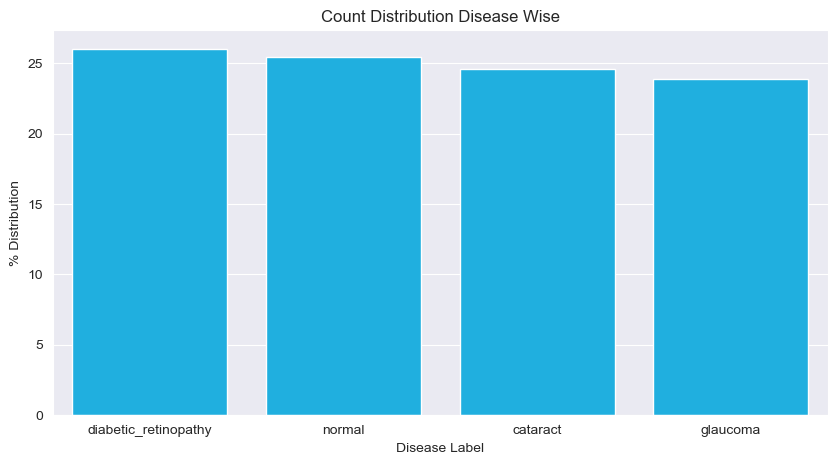

In [7]:
plt.figure(figsize=(10,5),dpi=100)
sns.barplot(opticDf.label.value_counts(normalize=True)*100,color='deepskyblue')
plt.xlabel("Disease Label")
plt.ylabel("% Distribution")
plt.title('Count Distribution Disease Wise')
plt.show()

## Image Exploration & Brief on Ocular Diseases
### Brief on Ocular Diseases
* **Normal:** Normal retinal images show a healthy eye without any issues. This is the baseline for comparison when looking for signs of disease.
* **Diabetic Retinopathy:** Diabetic Retinopathy is a condition that can happen in people with diabetes. It affects the blood vessels in the retina and can lead to vision problems. Early signs include tiny bulges and spots on the retina. If not caught early, it can worsen and cause serious vision loss.
* **Cataract:** Cataracts make the lens of the eye cloudy, which can blur vision. They are often related to aging but can also be caused by other factors like diabetes or eye injuries. People with cataracts may notice difficulty seeing at night or glare from bright lights. Surgery can help restore clear vision.

* **Glaucoma:** Glaucoma involves damage to the optic nerve, often due to high pressure in the eye. It can lead to vision loss if not treated. Many people don’t notice symptoms in the early stages, so regular eye check-ups are important for detection. There are different types, with open-angle glaucoma being the most common.

**Importance of Early Detection:**

Identification these diseases early is crucial to prevent vision loss. Regular eye exams can help identify problems before they become serious, making it important to analyze eye images for signs of these conditions.



In [8]:
def displayImg(sample,scaleImage = True):
    imgName,label = sample['filepath'].item().split('\\')[-1],sample['label'].item()
    path = sample['filepath'].item()
    img = mpimg.imread(path)

    if scaleImage:
        img = img / 255
        
    plt.figure(figsize= (6,6),dpi=80)
    imgplot = plt.imshow(img)
    plt.title(f"{imgName}:{label}",color= 'blue', fontsize= 12)
    plt.show()
    return img

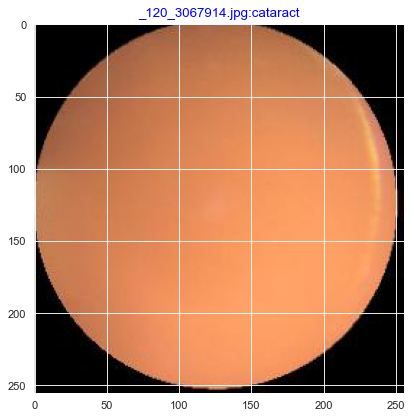

In [9]:
sample = opticDf.sample(1)
img = displayImg(sample)

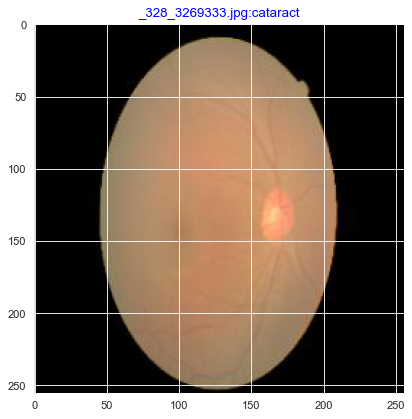

In [10]:
sample = opticDf.sample(1)
img = displayImg(sample)

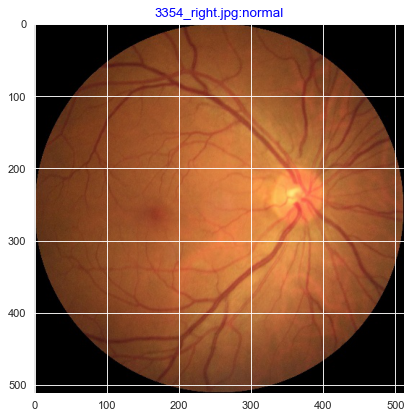

In [11]:
sample = opticDf.sample(1)
img = displayImg(sample)

In [12]:
print(img.shape)

(512, 512, 3)


---
## Data Splitting, Image Preprocessing and Generator

### Train Test Split
* Creation of Training, Validation and Testing Samples

In [13]:
opticDf.head()

,filepath,label
1361,C:\Users\asuto\Desktop\Work\Eye Diseases\datas...,diabetic_retinopathy
3466,C:\Users\asuto\Desktop\Work\Eye Diseases\datas...,normal
3969,C:\Users\asuto\Desktop\Work\Eye Diseases\datas...,normal
43,C:\Users\asuto\Desktop\Work\Eye Diseases\datas...,cataract
1079,C:\Users\asuto\Desktop\Work\Eye Diseases\datas...,diabetic_retinopathy


In [14]:
#Creating Training Samples and a Dummy DF
trainSamples,dumSamples = train_test_split(opticDf,test_size=0.3,stratify=opticDf['label'])
#Creating Testing and Validation Samples from the Dummy DF
testSamples,validSamples = train_test_split(dumSamples,test_size=0.5,stratify=dumSamples['label'])

In [15]:
print("Training Data Size:", trainSamples.shape[0])
print("Validation Data Size:", validSamples.shape[0])
print("Testing Data Size:", testSamples.shape[0])

Training Data Size: 2951
Validation Data Size: 633
Testing Data Size: 633


### Image Generator

In [16]:
img.shape

(512, 512, 3)

In [17]:
#Target Image Size. Original Image Size is (512,512)
imageSize = (512,512)
color = 'rgb'
colorChannel = 3
imageShape = (imageSize[0],imageSize[1],colorChannel)
batch_size = 8

imgGen = ImageDataGenerator(rescale = 1/255)

In [18]:
trainGen = imgGen.flow_from_dataframe(trainSamples,x_col='filepath',y_col='label',class_mode='categorical',color_mode=color,target_size=imageSize,batch_size=batch_size)
valGen = imgGen.flow_from_dataframe(validSamples,x_col='filepath',y_col='label',class_mode='categorical',color_mode=color,target_size=imageSize,batch_size=batch_size)
testGen = imgGen.flow_from_dataframe(testSamples,x_col='filepath',y_col='label',class_mode='categorical',color_mode=color,target_size=imageSize,batch_size=batch_size)

Found 2951 validated image filenames belonging to 4 classes.
Found 633 validated image filenames belonging to 4 classes.
Found 633 validated image filenames belonging to 4 classes.


---
## Model Development
Using the power of Convolution and Convolutional Neural Networks

### Dummy Model

In [31]:
tf.keras.backend.clear_session()
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=16,kernel_size=8,strides=(2,2),activation='relu',padding='same',input_shape=imageShape),
    tf.keras.layers.Conv2D(filters=32,kernel_size=10,strides=(1,1),activation='relu',padding='same'),
    tf.keras.layers.MaxPool2D(10),
    tf.keras.layers.Conv2D(filters=8,kernel_size=10,strides=(1,1),activation='relu',padding='same'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256,activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128,activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(4,activation='softmax')
])
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])


In [32]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 16)      3088      
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 256, 32)      51232     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 25, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 25, 25, 8)         25608     
                                                                 
 flatten (Flatten)           (None, 5000)              0         
                                                                 
 dense (Dense)               (None, 256)               1280256   
                                                        

In [33]:
@long_running
def modelTrainingFnx(model,epochs):
    tf.keras.backend.clear_session()
    # history = model.fit(x=trainGen,validation_data=valGen,epochs=epochs,verbose=0, callbacks=[TQDMNotebookCallback()])
    history = model.fit(x=trainGen,validation_data=valGen,epochs=epochs)
    return model,history 

In [34]:
%%time
telltimefnx()
model,history = modelTrainingFnx(model,epochs=120)
telltimefnx()

Time Now: 2024.09.21 12:03 AM
Epoch 1/120
369/369 [==============================] - 49s 130ms/step - loss: 1.1651 - accuracy: 0.4585 - val_loss: 0.8461 - val_accuracy: 0.5845
Epoch 2/120
369/369 [==============================] - 48s 130ms/step - loss: 0.8342 - accuracy: 0.5859 - val_loss: 0.7256 - val_accuracy: 0.6177
Epoch 3/120
369/369 [==============================] - 52s 140ms/step - loss: 0.7345 - accuracy: 0.6401 - val_loss: 0.6231 - val_accuracy: 0.7077
Epoch 4/120
369/369 [==============================] - 49s 133ms/step - loss: 0.6420 - accuracy: 0.7011 - val_loss: 0.5921 - val_accuracy: 0.7299
Epoch 5/120
369/369 [==============================] - 50s 135ms/step - loss: 0.6240 - accuracy: 0.7072 - val_loss: 0.5811 - val_accuracy: 0.7156
Epoch 6/120
369/369 [==============================] - 49s 134ms/step - loss: 0.5963 - accuracy: 0.7184 - val_loss: 0.5774 - val_accuracy: 0.7156
Epoch 7/120
369/369 [==============================] - 52s 141ms/step - loss: 0.6051 - accurac

In [35]:
historyDf = pd.DataFrame(history.history).reset_index()
historyDf['index'] += 1
historyDf.head()

,index,loss,accuracy,val_loss,val_accuracy
0,1,1.165127,0.458489,0.846114,0.584518
1,2,0.834163,0.585903,0.725638,0.617694
2,3,0.734526,0.640122,0.623075,0.707741
3,4,0.641992,0.701118,0.592109,0.729858
4,5,0.623979,0.707218,0.581076,0.715640


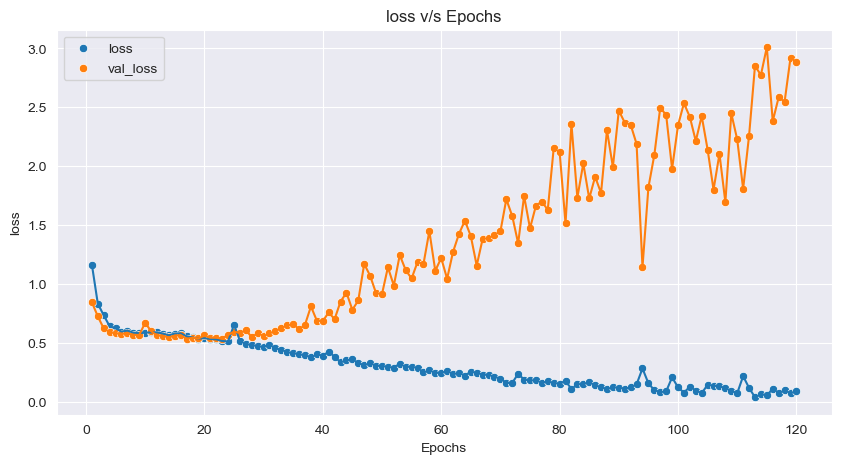

In [36]:
metric = 'loss'

plt.figure(figsize=(10,5),dpi=100)
sns.lineplot(data=historyDf,x='index',y=metric)
sns.scatterplot(data=historyDf,x='index',y=metric,label=metric)

sns.lineplot(data=historyDf,x='index',y='val_loss')
sns.scatterplot(data=historyDf,x='index',y='val_loss',label='val_loss')

plt.title(f'{metric} v/s Epochs')
plt.xlabel('Epochs')
plt.show()

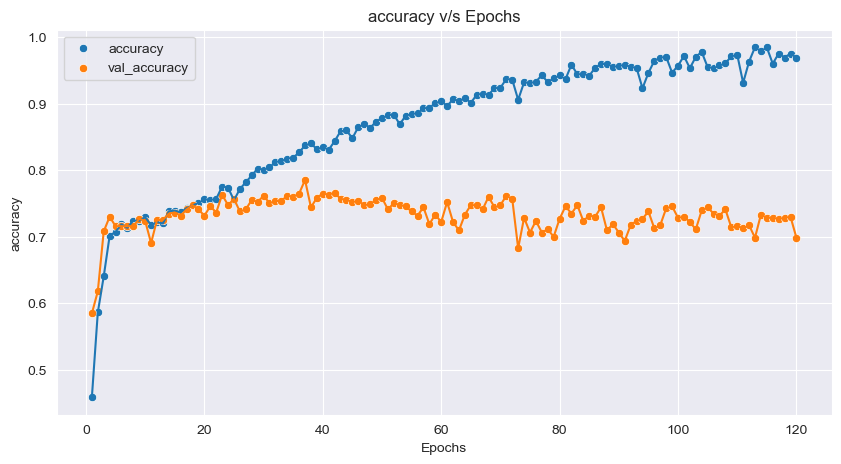

In [37]:
metric = 'accuracy'

plt.figure(figsize=(10,5),dpi=100)
sns.lineplot(data=historyDf,x='index',y=metric)
sns.scatterplot(data=historyDf,x='index',y=metric,label=metric)

sns.lineplot(data=historyDf,x='index',y='val_accuracy')
sns.scatterplot(data=historyDf,x='index',y='val_accuracy',label='val_accuracy')

plt.title(f'{metric} v/s Epochs')
plt.xlabel('Epochs')
plt.show()